# 영화감상 텍스트 분석
### 1. 순서
1. 데이터 준비와 확인
2. 데이터 로더 구성
3. 모델 구성을 위한 데이터 분석 및 가공
4. Validation set 구성
5. 모델 구성
6. Loss, Accuracy 분석
7. Embedding Layer 성능 확인
8. Word2Vec 이용하기
9. 회고

In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras

from konlpy.tag import Mecab
from collections import Counter
from gensim.models.keyedvectors import Word2VecKeyedVectors
from gensim.models import KeyedVectors, Word2Vec

### 1. 데이터 준비와 확인

In [2]:
train_data = pd.read_table('~/aiffel/sentiment_classification/data/ratings_train.txt')
test_data = pd.read_table('~/aiffel/sentiment_classification/data/ratings_test.txt')

train_data.head()

,id,document,label
0,9976970,아 더빙.. 진짜 짜증나네요 목소리,0
1,3819312,흠...포스터보고 초딩영화줄....오버연기조차 가볍지 않구나,1
2,10265843,너무재밓었다그래서보는것을추천한다,0
3,9045019,교도소 이야기구먼 ..솔직히 재미는 없다..평점 조정,0
4,6483659,사이몬페그의 익살스런 연기가 돋보였던 영화!스파이더맨에서 늙어보이기만 했던 커스틴 ...,1


### 2. 데이터로더 구성

In [3]:
tokenizer = Mecab()
stopwords = ['의','가','이','은','들','는','좀','잘','걍','과','도','를','으로','자','에','와','한','하다']

def load_data(train_data, test_data, num_words=10000):
    # train data 데이터 중복 제거
    train_data.drop_duplicates(subset=['document'], inplace=True)
    # train data NaN 결측치 제거
    train_data = train_data.dropna(how='any')
    
    # test data도 위와 동일하게 처리
    test_data.drop_duplicates(subset=['document'], inplace=True)
    test_data = test_data.dropna(how = 'any')
    
    # train data를 한국어 토크나이저로 토큰화
    X_train = []
    for sentence in train_data['document']:
        temp_X = tokenizer.morphs(sentence) # 토큰화
        temp_X = [word for word in temp_X if not word in stopwords] #불용어 제거
        X_train.append(temp_X)
        
    # test data에 대해 같게 실행
    X_test = []
    for sentence in test_data['document']:
        temp_X = tokenizer.morphs(sentence) # 토큰화
        temp_X = [word for word in temp_X if not word in stopwords] #불용어 제거
        X_test.append(temp_X)
        
    # counter을 쓰기 위해 2차원 리스트인 X_train을 1차원 배열로 변환 뒤 다시 리스트로 변환
    words = np.concatenate(X_train).tolist()
    counter = Counter(words)
    counter = counter.most_common(10000-4)
    vocab = ['<PAD>', '<BOS>', '<UNK>','<UNUSED>'] + [key for key, _ in counter]
    word_to_index = {word:index for index, word in enumerate(vocab)}
    
    # 텍스트 스트링을 사전 인덱스 스트링으로 변환
    def wordlist_to_indexlist(wordlist):
        return [word_to_index[word] if word in word_to_index else word_to_index['<UNK>'] for word in wordlist]
    
    X_train = list(map(wordlist_to_indexlist, X_train))
    X_test = list(map(wordlist_to_indexlist, X_test))
    
    return X_train, np.array(list(train_data['label'])), X_test, np.array(list(test_data['label'])), word_to_index
X_train, y_train, X_test, y_test, word_to_index = load_data(train_data, test_data)

In [4]:
# word: index의 형태를 index: word의 형태로 바꿔줌
index_to_word = {index:word for word, index in word_to_index.items()}

In [5]:
# 문장 1개를 활용할 딕셔너리와 함께 주면, 단어 인덱스 리스트 벡터로 변환해 주는 함수
# 단, 모든 문장은 <BOS>로 시작하는 것으로 함
def get_encoded_sentence(sentence, word_to_index):
    return [word_to_index['<BOS>']]+[word_to_index[word] if word in word_to_index else word_to_index['<UNK>'] for word in sentence.split()]

# 여러 개의 문장 리스트를 한꺼번에 단어 인덱스 리스트 벡터로 encode해 주는 함수
def get_encoded_sentences(sentences, word_to_index):
    return [get_encoded_sentence(sentence, word_to_index) for sentence in sentences]

# 숫자 벡터로 encode된 문장을 원래대로 decode하는 함수
def get_decoded_sentence(encoded_sentence, index_to_word):
    return ' '.join(index_to_word[index] if index in index_to_word else '<UNK>' for index in encoded_sentence[1:])  #[1:]를 통해 <BOS>를 제외

# 여러 개의 숫자 벡터로 encode된 문장을 한꺼번에 원래대로 decode하는 함수
def get_decoded_sentences(encoded_sentences, index_to_word):
    return [get_decoded_sentence(encoded_sentence, index_to_word) for encoded_sentence in encoded_sentences]

### 3. 모델 구성을 위한 데이터 분석 및 가공

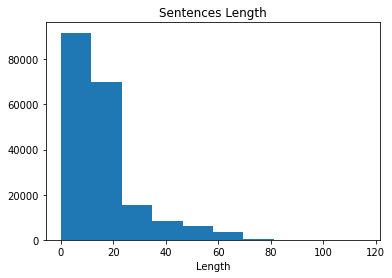

문장 길이 평균 :  15.96940191154864
문장 길이 최대 :  116
전체 문장의 0.9269270345399536%가 maxlen 설정값 이내에 포함됩니다. 


In [6]:
total_data_text = X_train+X_test
num_tokens = [len(tokens) for tokens in total_data_text]
num_tokens = np.array(num_tokens)
plt.hist(num_tokens)
plt.title('Sentences Length')
plt.xlabel('Length')
plt.show()
print('문장 길이 평균 : ', np.mean(num_tokens))
print('문장 길이 최대 : ', np.max(num_tokens))

max_len = 40
print('전체 문장의 {}%가 maxlen 설정값 이내에 포함됩니다. '.format(np.sum(num_tokens < max_len) / len(num_tokens)))

In [7]:
# 분포에 따라 최대 길이를 40으로 지정
# padding = pre로 지정
X_train = tf.keras.preprocessing.sequence.pad_sequences(X_train,
                                                        value=word_to_index["<PAD>"],
                                                        padding='pre',
                                                        maxlen=max_len)

X_test = tf.keras.preprocessing.sequence.pad_sequences(X_test,
                                                       value=word_to_index["<PAD>"],
                                                       padding='pre',
                                                       maxlen=max_len)

In [8]:
# 결과 확인
print(f"X_train:\n{X_train}\nX_train_length: {len(X_train)}\n")
print(f"X_test: \n{X_test}\nX_test_length: {len(X_test)}")

X_train:
[[   0    0    0 ...   20   33  748]
 [   0    0    0 ...   15   44  391]
 [   0    0    0 ...   24  205    2]
 ...
 [   0    0    0 ... 2710    6   18]
 [   0    0    0 ...   60  395 8572]
 [   0    0    0 ...   88 2740    5]]
X_train_length: 146182

X_test: 
[[   0    0    0 ...    0  832  130]
 [   0    0    0 ...    0    0    2]
 [   0    0    0 ... 3557   73  917]
 ...
 [   0    0    0 ...    8   12 3424]
 [   0    0    0 ...   67  323   43]
 [   0    0    0 ...  179   63 1058]]
X_test_length: 49157


### 4. Validation set 구성

In [9]:
# validation set 설정
X_val = X_train[:10000]
y_val = y_train[:10000]

# train set 재설정
partial_X_train = X_train[10000:]
partial_y_train = y_train[10000:]

### 5. 모델 구성
##### 1. RNN(LSTM)

In [10]:
vocab_size = 10000 
word_vector_dim = 200

lstm_model = tf.keras.Sequential()
lstm_model.add(tf.keras.layers.Embedding(vocab_size, word_vector_dim, input_shape=(None,)))
lstm_model.add(tf.keras.layers.LSTM(128)) 
lstm_model.add(tf.keras.layers.Dense(8, activation='relu'))
lstm_model.add(tf.keras.layers.Dense(1, activation='sigmoid'))

lstm_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, None, 200)         2000000   
_________________________________________________________________
lstm (LSTM)                  (None, 128)               168448    
_________________________________________________________________
dense (Dense)                (None, 8)                 1032      
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 9         
Total params: 2,169,489
Trainable params: 2,169,489
Non-trainable params: 0
_________________________________________________________________


In [11]:
lstm_model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
              
epochs=3

lstm_history = lstm_model.fit(partial_X_train,
                    partial_y_train,
                    epochs=epochs,
                    batch_size=512,
                    validation_data=(X_val, y_val),
                    verbose=1)

Epoch 1/3
266/266 [==============================] - 7s 14ms/step - loss: 0.3997 - accuracy: 0.8165 - val_loss: 0.3347 - val_accuracy: 0.8514
Epoch 2/3
266/266 [==============================] - 3s 13ms/step - loss: 0.3107 - accuracy: 0.8664 - val_loss: 0.3224 - val_accuracy: 0.8597
Epoch 3/3
266/266 [==============================] - 3s 13ms/step - loss: 0.2745 - accuracy: 0.8826 - val_loss: 0.3184 - val_accuracy: 0.8604


##### 2. CNN

In [12]:
cnn_model = tf.keras.Sequential()
cnn_model.add(tf.keras.layers.Embedding(vocab_size, word_vector_dim, input_shape=(None,)))
cnn_model.add(tf.keras.layers.Conv1D(16, 7, padding='same', activation='relu'))
cnn_model.add(tf.keras.layers.MaxPooling1D(5))
cnn_model.add(tf.keras.layers.Conv1D(16, 7, padding='same', activation='relu'))
cnn_model.add(tf.keras.layers.GlobalMaxPooling1D())
cnn_model.add(tf.keras.layers.Dense(8, activation='relu'))
cnn_model.add(tf.keras.layers.Dense(1, activation='sigmoid'))  # 최종 출력은 긍정/부정을 나타내는 1dim

cnn_model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, None, 200)         2000000   
_________________________________________________________________
conv1d (Conv1D)              (None, None, 16)          22416     
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, None, 16)          0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, None, 16)          1808      
_________________________________________________________________
global_max_pooling1d (Global (None, 16)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 8)                 136       
_________________________________________________________________
dense_3 (Dense)              (None, 1)                

In [13]:
cnn_model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
              
cnn_history = cnn_model.fit(partial_X_train,
                    partial_y_train,
                    epochs=epochs,
                    batch_size=512,
                    validation_data=(X_val, y_val),
                    verbose=1)

Epoch 1/3
266/266 [==============================] - 4s 8ms/step - loss: 0.4143 - accuracy: 0.8109 - val_loss: 0.3253 - val_accuracy: 0.8558
Epoch 2/3
266/266 [==============================] - 2s 6ms/step - loss: 0.2870 - accuracy: 0.8792 - val_loss: 0.3091 - val_accuracy: 0.8667
Epoch 3/3
266/266 [==============================] - 2s 6ms/step - loss: 0.2296 - accuracy: 0.9084 - val_loss: 0.3202 - val_accuracy: 0.8674


##### 3. GlobalMax Pooling

In [14]:
gm_model = tf.keras.Sequential()
gm_model.add(tf.keras.layers.Embedding(vocab_size, word_vector_dim, input_shape=(None,)))
gm_model.add(tf.keras.layers.GlobalMaxPooling1D())
gm_model.add(tf.keras.layers.Dense(8, activation='relu'))
gm_model.add(tf.keras.layers.Dense(1, activation='sigmoid'))  # 최종 출력은 긍정/부정을 나타내는 1dim 입니다.

gm_model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, None, 200)         2000000   
_________________________________________________________________
global_max_pooling1d_1 (Glob (None, 200)               0         
_________________________________________________________________
dense_4 (Dense)              (None, 8)                 1608      
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 9         
Total params: 2,001,617
Trainable params: 2,001,617
Non-trainable params: 0
_________________________________________________________________


In [15]:
gm_model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
              
gm_history = gm_model.fit(partial_X_train,
                    partial_y_train,
                    epochs=epochs,
                    batch_size=512,
                    validation_data=(X_val, y_val),
                    verbose=1)

Epoch 1/3
266/266 [==============================] - 2s 5ms/step - loss: 0.4805 - accuracy: 0.7811 - val_loss: 0.3433 - val_accuracy: 0.8505
Epoch 2/3
266/266 [==============================] - 1s 4ms/step - loss: 0.3139 - accuracy: 0.8673 - val_loss: 0.3299 - val_accuracy: 0.8555
Epoch 3/3
266/266 [==============================] - 1s 4ms/step - loss: 0.2683 - accuracy: 0.8908 - val_loss: 0.3357 - val_accuracy: 0.8563


### 6. Loss, Accuracy 분석
##### 1. RNN(LSTM)

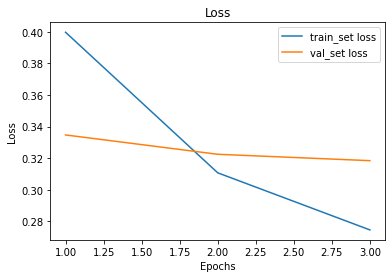

1537/1537 [==============================] - 4s 3ms/step - loss: 0.3305 - accuracy: 0.8553


[0.3304743766784668, 0.8553003668785095]

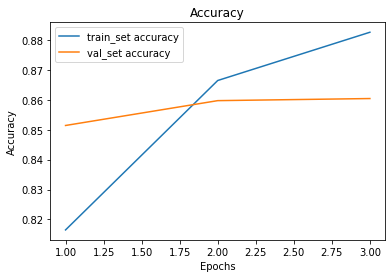

In [16]:
lstm_history_dict = lstm_history.history

lstm_loss = lstm_history_dict['loss']
lstm_val_loss = lstm_history_dict['val_loss']
lstm_accuracy = lstm_history_dict['accuracy']
lstm_val_accuracy = lstm_history_dict['val_accuracy']
epochs = range(1, len(lstm_loss)+1)

plt.plot(epochs, lstm_loss, label='train_set loss')
plt.plot(epochs, lstm_val_loss, label='val_set loss')
plt.title('Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

plt.plot(epochs, lstm_accuracy, label='train_set accuracy')
plt.plot(epochs, lstm_val_accuracy, label='val_set accuracy')
plt.title('Accuracy')
plt.legend()
plt.xlabel('Epochs')
plt.ylabel('Accuracy')

lstm_model.evaluate(X_test, y_test, verbose=1)

##### 2. CNN

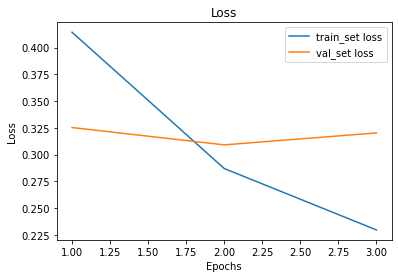

1537/1537 [==============================] - 3s 2ms/step - loss: 0.3310 - accuracy: 0.8600


[0.33098894357681274, 0.8600199222564697]

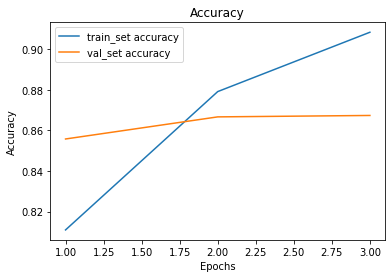

In [17]:
cnn_history_dict = cnn_history.history

cnn_loss = cnn_history_dict['loss']
cnn_val_loss = cnn_history_dict['val_loss']
cnn_accuracy = cnn_history_dict['accuracy']
cnn_val_accuracy = cnn_history_dict['val_accuracy']
epochs = range(1, len(cnn_loss)+1)

plt.plot(epochs, cnn_loss, label='train_set loss')
plt.plot(epochs, cnn_val_loss, label='val_set loss')
plt.title('Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

plt.plot(epochs, cnn_accuracy, label='train_set accuracy')
plt.plot(epochs, cnn_val_accuracy, label='val_set accuracy')
plt.title('Accuracy')
plt.legend()
plt.xlabel('Epochs')
plt.ylabel('Accuracy')

cnn_model.evaluate(X_test, y_test, verbose=1)

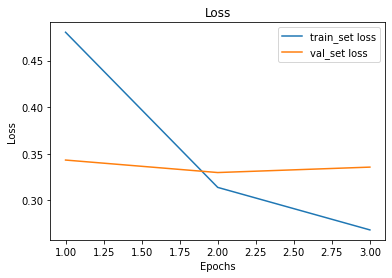

1537/1537 [==============================] - 2s 2ms/step - loss: 0.3484 - accuracy: 0.8516


[0.34841206669807434, 0.8515979647636414]

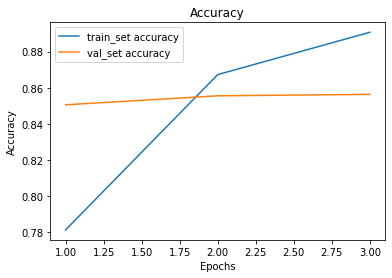

In [18]:
gm_history_dict = gm_history.history

gm_loss = gm_history_dict['loss']
gm_val_loss = gm_history_dict['val_loss']
gm_accuracy = gm_history_dict['accuracy']
gm_val_accuracy = gm_history_dict['val_accuracy']
epochs = range(1, len(gm_loss)+1)

plt.plot(epochs, gm_loss, label='train_set loss')
plt.plot(epochs, gm_val_loss, label='val_set loss')
plt.title('Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

plt.plot(epochs, gm_accuracy, label='train_set accuracy')
plt.plot(epochs, gm_val_accuracy, label='val_set accuracy')
plt.title('Accuracy')
plt.legend()
plt.xlabel('Epochs')
plt.ylabel('Accuracy')

gm_model.evaluate(X_test, y_test, verbose=1)

### 7. Embedding Layer 성능 확인

In [19]:
lstm_embedding_layer = lstm_model.layers[0]
lstm_weights = lstm_embedding_layer.get_weights()[0]
lstm_file_path = os.getenv('HOME')+'/aiffel/sentiment_classification/data/lstm.txt'
lstm_f = open(lstm_file_path, 'w')
lstm_f.write('{} {}\n'.format(vocab_size-4, word_vector_dim))

lstm_vectors = lstm_model.get_weights()[0]
for i in range(4,vocab_size):
    lstm_f.write('{} {}\n'.format(index_to_word[i], ' '.join(map(str, list(lstm_vectors[i, :])))))
lstm_f.close()

In [20]:
word_vectors = Word2VecKeyedVectors.load_word2vec_format(lstm_file_path, binary=False)
word_vectors.similar_by_word('재미')

[('너무', 0.7178363800048828),
 ('이렇게', 0.7175489068031311),
 ('이건', 0.7005287408828735),
 ('완전', 0.6868083477020264),
 ('기억나', 0.6835588216781616),
 ('흥미', 0.6803199052810669),
 ('투입', 0.6714426279067993),
 ('합리', 0.6579347848892212),
 ('토끼', 0.6564505100250244),
 ('몰입', 0.6521011590957642)]

In [21]:
cnn_embedding_layer = cnn_model.layers[0]
cnn_weights = cnn_embedding_layer.get_weights()[0]
cnn_file_path = os.getenv('HOME')+'/aiffel/sentiment_classification/data/cnn.txt'
cnn_f = open(cnn_file_path, 'w')
cnn_f.write('{} {}\n'.format(vocab_size-4, word_vector_dim))

cnn_vectors = cnn_model.get_weights()[0]
for i in range(4,vocab_size):
    cnn_f.write('{} {}\n'.format(index_to_word[i], ' '.join(map(str, list(cnn_vectors[i, :])))))
cnn_f.close()

In [22]:
word_vectors = Word2VecKeyedVectors.load_word2vec_format(cnn_file_path, binary=False)
word_vectors.similar_by_word('재미')

[('공감', 0.5163542032241821),
 ('되게', 0.5145019888877869),
 ('지날수록', 0.5137636065483093),
 ('매력', 0.5084421634674072),
 ('다름', 0.491557240486145),
 ('긴장감', 0.4895498752593994),
 ('기쁨', 0.48704349994659424),
 ('잼', 0.48646461963653564),
 ('세염', 0.4845619797706604),
 ('존재감', 0.4766695499420166)]

In [23]:
gm_embedding_layer = gm_model.layers[0]
gm_weights = gm_embedding_layer.get_weights()[0]
gm_file_path = os.getenv('HOME')+'/aiffel/sentiment_classification/data/gm.txt'
gm_f = open(gm_file_path, 'w')
gm_f.write('{} {}\n'.format(vocab_size-4, word_vector_dim))

gm_vectors = gm_model.get_weights()[0]
for i in range(4,vocab_size):
    gm_f.write('{} {}\n'.format(index_to_word[i], ' '.join(map(str, list(gm_vectors[i, :])))))
gm_f.close()

In [24]:
word_vectors = Word2VecKeyedVectors.load_word2vec_format(gm_file_path, binary=False)
word_vectors.similar_by_word('재미')

[('되', 0.4770109951496124),
 ('고', 0.40470728278160095),
 ('스릴', 0.404150128364563),
 ('예쁜', 0.39660802483558655),
 ('것', 0.387149453163147),
 ('모임', 0.38396942615509033),
 ('사탕', 0.3621423840522766),
 ('~', 0.3610564172267914),
 ('주', 0.3532056510448456),
 ('아', 0.35183602571487427)]

### 8. Word2Vec 이용하기

In [25]:
word2vec_path = os.getenv('HOME') + '/aiffel/sentiment_classification/ko.bin'
word2vec = Word2Vec.load(word2vec_path)

In [26]:
word2vec.similar_by_word('재미')

/tmp/ipykernel_8664/3642096145.py:1: DeprecationWarning: Call to deprecated `similar_by_word` (Method will be removed in 4.0.0, use self.wv.similar_by_word() instead).
  word2vec.similar_by_word('재미')


[('취미', 0.5857348442077637),
 ('유머', 0.5140613913536072),
 ('매력', 0.5105490684509277),
 ('흥미', 0.4988338351249695),
 ('공짜', 0.4960595667362213),
 ('일자리', 0.49294644594192505),
 ('즐거움', 0.48700767755508423),
 ('비애', 0.4836210310459137),
 ('관객', 0.48286449909210205),
 ('향수', 0.4823310971260071)]

In [27]:
vocab_size = 10000    
word_vector_dim = 200  
embedding_matrix = np.random.rand(vocab_size, word_vector_dim)

# embedding_matrix에 Word2Vec 워드 벡터를 단어 하나씩마다 차례차례 카피한다.
for i in range(4,vocab_size):
    if index_to_word[i] in word2vec:
        embedding_matrix[i] = word2vec[index_to_word[i]]

/tmp/ipykernel_8664/489849284.py:7: DeprecationWarning: Call to deprecated `__contains__` (Method will be removed in 4.0.0, use self.wv.__contains__() instead).
  if index_to_word[i] in word2vec:
/tmp/ipykernel_8664/489849284.py:8: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  embedding_matrix[i] = word2vec[index_to_word[i]]


In [28]:
from tensorflow.keras.initializers import Constant

vocab_size = 10000    
word_vector_dim = 200  

# 모델 구성
model = tf.keras.Sequential()
model.add(tf.keras.layers.Embedding(vocab_size, 
                                 word_vector_dim, 
                                 embeddings_initializer=Constant(embedding_matrix),  # 카피한 임베딩을 여기서 활용
                                 input_length=max_len, 
                                 trainable=True))   
model.add(tf.keras.layers.Conv1D(16, 7, padding='same',activation='relu'))
model.add(tf.keras.layers.MaxPooling1D(5))
model.add(tf.keras.layers.Conv1D(16, 7, padding='same', activation='relu'))
model.add(tf.keras.layers.GlobalMaxPooling1D())
model.add(tf.keras.layers.Dense(8, activation='relu'))
model.add(tf.keras.layers.Dense(1, activation='sigmoid')) 

model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_3 (Embedding)      (None, 40, 200)           2000000   
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 40, 16)            22416     
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 8, 16)             0         
_________________________________________________________________
conv1d_3 (Conv1D)            (None, 8, 16)             1808      
_________________________________________________________________
global_max_pooling1d_2 (Glob (None, 16)                0         
_________________________________________________________________
dense_6 (Dense)              (None, 8)                 136       
_________________________________________________________________
dense_7 (Dense)              (None, 1)                

In [29]:
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
              
epochs=3 

history = model.fit(partial_X_train,
                    partial_y_train,
                    epochs=epochs,
                    batch_size=512,
                    validation_data=(X_val, y_val),
                    verbose=1)

Epoch 1/3
266/266 [==============================] - 2s 7ms/step - loss: 0.5546 - accuracy: 0.7013 - val_loss: 0.4274 - val_accuracy: 0.8039
Epoch 2/3
266/266 [==============================] - 2s 6ms/step - loss: 0.3794 - accuracy: 0.8319 - val_loss: 0.3598 - val_accuracy: 0.8397
Epoch 3/3
266/266 [==============================] - 2s 6ms/step - loss: 0.3212 - accuracy: 0.8627 - val_loss: 0.3462 - val_accuracy: 0.8454


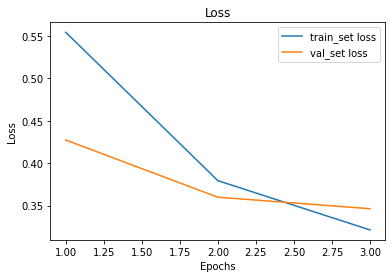

1537/1537 [==============================] - 3s 2ms/step - loss: 0.3569 - accuracy: 0.8445


[0.35694628953933716, 0.8445389270782471]

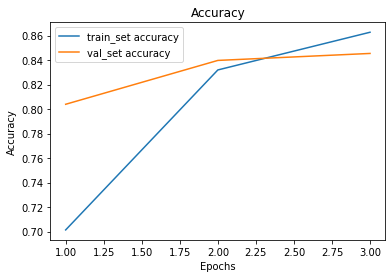

In [30]:
history_dict = history.history

loss = history_dict['loss']
val_loss = history_dict['val_loss']
accuracy = history_dict['accuracy']
val_accuracy = history_dict['val_accuracy']
epochs = range(1, len(loss)+1)

plt.plot(epochs, loss, label='train_set loss')
plt.plot(epochs, val_loss, label='val_set loss')
plt.title('Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

plt.plot(epochs, accuracy, label='train_set accuracy')
plt.plot(epochs, val_accuracy, label='val_set accuracy')
plt.title('Accuracy')
plt.legend()
plt.xlabel('Epochs')
plt.ylabel('Accuracy')

model.evaluate(X_test, y_test, verbose=1)

### 9. 회고

 처음엔 epoch 값을 30으로 두고 학습을 시켰는데, 전반적으로 과적합이 일어난 것으로 보인다. callback을 설정해서 전체 epoch가 끝나기 전 성능 향상이 없는 경우 훈련을 멈추는 식으로 어느 부분이 문제인지 확인해볼 수 있을 것 같다. 전반적으로 0-5 까지는 validation set의 정확도가 향상되다가 그 이후로 줄어드는 경향을 보였다. 그래서 epoch 값을 3으로 설정해 다시 학습을 시켜봤지만, epoch가 30일 때 정확도가 82-84%였다면 3으로 조정하고 나서는 85%-86% 정도로, 큰 변화를 보이진 않았다.
 한편 Word2Vec을 이용할 경우 similar_by_word의 결과값에서 유사도가 가장 높았지만, 모델의 정확성 측면에선 다른 모델보다 높지 않은 것으로 나왔다. 다양한 값을 조절해봤지만 큰 향상은 되지 않아 이유를 더 찾아봐야할 것 같다. 